In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
from tflearn.layers.core import fully_connected
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
%matplotlib inline

## Data acquisition

Load the data.

In [6]:
data_dir = 'data'
files = os.listdir(data_dir)
df = pd.DataFrame(columns=['record', 'distance', 'speed'])

def get_record(distance, speed):
    
    return df['record'][ (df['distance'] == distance) & (df['speed'] == speed) ].tolist()[0]


for f in files:
    if '.wav' not in f:
        continue
    fs, data = wav.read(os.path.join(data_dir, f))
    decoded_classes = [ int(s) for s in re.findall(r'-?\d+', f) ]
    # put the data into the DataFrame
    df = df.append(dict(
        { 'record'   : np.divide(data, np.max(data)), 
          'distance' : decoded_classes[0],
          'speed'    : decoded_classes[1] }), ignore_index=True)
    
DISTANCES = sorted(df.distance.unique())
SPEEDS = sorted(df.speed.unique())

### Exploration of raw data

Plot several raw signals for several speeds and distances.

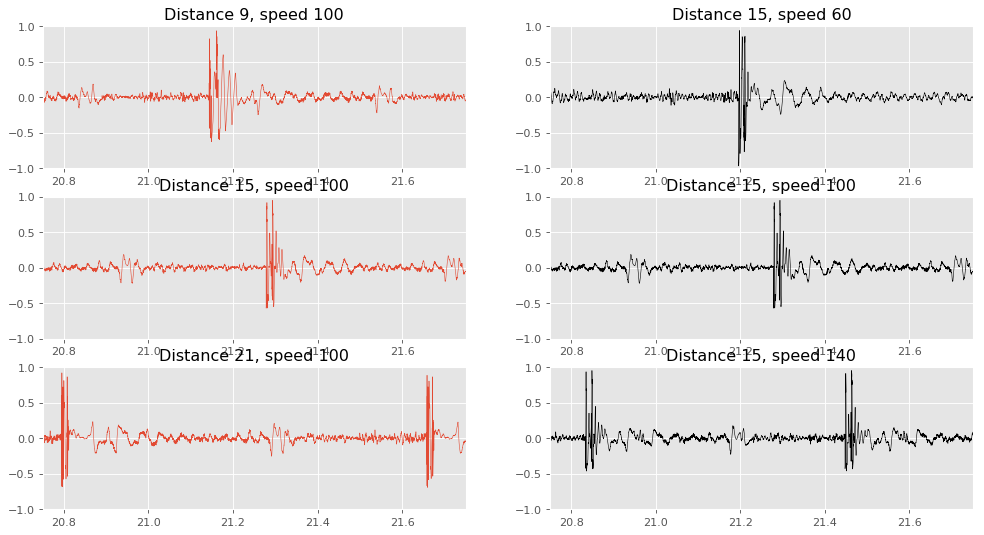

In [7]:
plt.figure(num=None, figsize=(15, 8), dpi=80)
plt.style.use('ggplot')

PLT_DISTANCE = 15
PLT_SPEED = 100

# plot for varying speed
for speed in range(60, 150, 40):
    data = get_record(PLT_DISTANCE, speed)
    plt.subplot(3, 2, int(speed / 40) * 2)
    timeline = np.linspace(0, len(data) / 44100., len(data))
    plt.plot(timeline, data, color='k', linewidth=.5)
    plt.xlim((20.75, 21.75))
    plt.ylim((-1, 1))
    plt.title('Distance %d, speed %d' % (PLT_DISTANCE, speed))
    
# plot for varying distance
for distance in range(9, 22, 6):
    data = get_record(distance, PLT_SPEED)
    plt.subplot(3, 2, int(distance / 7) * 2 - 1)
    timeline = np.linspace(0, len(data) / 44100., len(data))
    plt.plot(timeline, data, linewidth=.5)
    plt.xlim((20.75, 21.75))
    plt.ylim((-1, 1))
    plt.title('Distance %d, speed %d' % (distance, PLT_SPEED))

## Finding peaks

In [8]:
EXPECTED_CONTACTS = 100
THRESHOLD = .6 #1844146018536
FRAGMENT_SIZE = 2048
SAMPLES_BETWEEN_CONTACTS = 8192

def find_peaks(x, method='last_peaks'):
    above_th = pd.Series(x) > THRESHOLD
    # find every threshold transgression
    above_th = pd.Series(above_th.index[above_th == True].tolist()).astype(int)
    diff = above_th.diff(periods=-1).abs()
    if method == 'first_peaks':
        diff = diff.shift(1).fillna(SAMPLES_BETWEEN_CONTACTS)
    peaks_indices = diff.index[diff >= SAMPLES_BETWEEN_CONTACTS].tolist()
    peaks_indices.append(len(above_th) - 1)
    peaks = above_th[peaks_indices].reset_index(drop=True)
    return peaks

def extract_peaks(d, peaks):
    idx_peaks = pd.Index(peaks)
    contacts = []
    for c_idx in peaks:
        contacts.append(d[c_idx:c_idx + FRAGMENT_SIZE].tolist())
    return contacts

In [9]:
contact_signals = pd.DataFrame()

for i in range(len(df)):
    speed = df.at[i, 'speed']
    distance = df.at[i, 'distance']
    d = pd.Series(df.at[i, 'record'])
    peaks = find_peaks(d.abs())
    if len(peaks) != EXPECTED_CONTACTS:
        print('Unexpected amount of contacts (%d) in set distance %d - speed %d' 
              % (len(peaks), distance, speed))
    contacts = extract_peaks(d, peaks)
    contact_signals = contact_signals.append([[speed, distance] + contacts], ignore_index=True)
    
contact_signals.rename(columns={ 0 : 'speed', 1 : 'distance' }, inplace=True)
last_col = contact_signals.columns[-1]
contact_signals.rename(columns=dict(zip(range(2, last_col), range(0, last_col-2))), inplace=True)
contact_signals.rename(columns={ 101 : 99 }, inplace=True)

Unexpected amount of contacts (99) in set distance 5 - speed 160
Unexpected amount of contacts (99) in set distance 7 - speed 160


/media/luca/LocalDiskAsWell/python_projects/venv/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


array([[ 0.61915519,  0.58186972,  0.5508624 , ..., -0.03913705,
        -0.03961798, -0.04020712]])

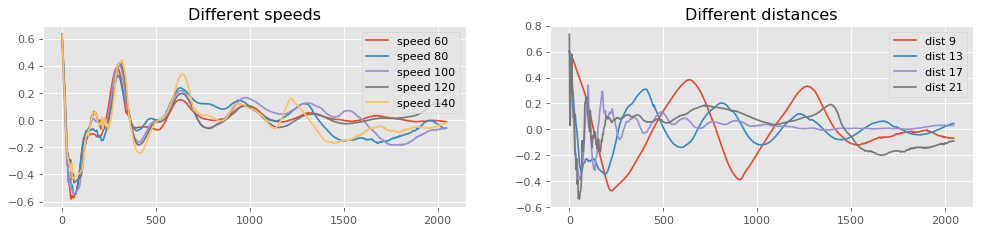

In [10]:
plt.figure(num=None, figsize=(15, 3), dpi=80)
plt.subplot(1, 2, 1)
for speed in range(60, 150, 20): 
    data = contact_signals[10][ (contact_signals['distance'] == PLT_DISTANCE) 
                               & (contact_signals['speed'] == speed) ].tolist()[0]
    plt.plot(data, label='speed %d' % speed)
    plt.title('Different speeds')
plt.legend()
plt.subplot(1, 2, 2)  
for distance in range(9, 22, 4):
    data = contact_signals[10][ (contact_signals['distance'] == distance) 
                               & (contact_signals['speed'] == PLT_SPEED) ].tolist()[0]
    plt.plot(data, label='dist %d' % distance)
    plt.title('Different distances')
plt.legend()
np.mean(contact_signals.loc[(contact_signals['distance'] == PLT_DISTANCE) 
                               & (contact_signals['speed'] == speed)].iloc[:, 2:99].values.tolist(), axis=1)

/media/luca/LocalDiskAsWell/python_projects/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:737: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:738: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:739: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:740: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


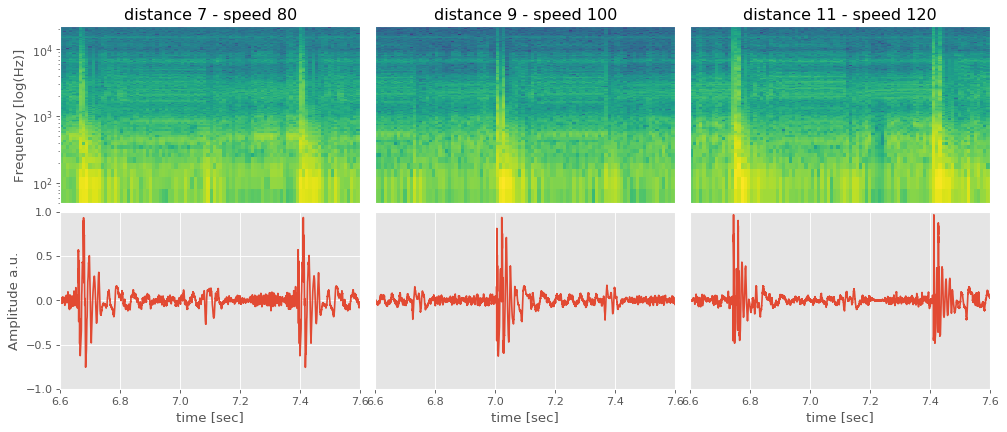

In [11]:
import matplotlib.gridspec as gridspec

fig = plt.figure(num=None, figsize=(15, 6), dpi=80)
outer = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.2)

SEGMENT_LEN = 535
FRAMERATE = 44100.

def generate_spectrogram(data):
    '''
    Generates a spectrogram with logarithmically scaled frequency dimension.
    '''
    f, t, Sxx = signal.spectrogram(data, fs=FRAMERATE, scaling='density', mode='psd', nperseg=SEGMENT_LEN, 
                                 nfft=SEGMENT_LEN*2)
    Sxx = np.log(Sxx)
    return f, t, Sxx

for i in range(3):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.2, hspace=0.05)
    ax = plt.Subplot(fig, inner[0])
    ax.set_title("distance %d - speed %d" % (i * 2 + 7, i * 20 + 80))
    if i == 0:
        ax.set_ylabel("Frequency [log(Hz)]")
    else:
        ax.get_yaxis().set_visible(False)
    dat = get_record(i * 2 + 7, i * 20 + 80)
    f, t, Sxx = generate_spectrogram(dat)
    timeline = np.linspace(0, len(dat) / 44100., len(dat))
    ax.pcolormesh(t, f, Sxx, label='spectrogram')
    ax.set_yscale('log')
    ax.set_ylim((50, 22050))
    ax.get_xaxis().set_visible(False)
    # show two seconds of the signals spectrogram
    ax.set_xlim((6.6, 7.6))
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[1])
    ax.set_xlim((6.6, 7.6))
    ax.set_ylim((-1., 1.))
    ax.set_xlabel("time [sec]")
    if i == 0:
        ax.set_ylabel("Amplitude a.u.")
    else:
        ax.get_yaxis().set_ticks([])
    # plot raw signal
    ax.plot(timeline, dat)
    fig.add_subplot(ax)

In [12]:
from sklearn.manifold import TSNE

# scale data
contacts = contact_signals.iloc[:, 2:].dropna().values.tolist()
contacts = np.reshape(contacts, [61 * 100, 2048])
#X_train, X_test, y_train, y_test = train_test_split(contacts, y, test_size=test_percentage, random_state=42)

tsne = TSNE(n_components=2, random_state=0)
#x_test_2d = tsne.fit_transform(contacts)
np.shape(contact_signals[contact_signals.distance == 11].iloc[:, 2:].values[0][0])

(2048,)

In [13]:
FRAMERATE = 44100.
SEGMENT_LEN = 1024

def generate_spectrum(data):
    return signal.welch(data,
                           fs=FRAMERATE,
                           window='hann',
                           nperseg=SEGMENT_LEN,
                           nfft=SEGMENT_LEN*2)
contact_signals

,speed,distance,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,100,11,"[0.6034554711626743, 0.5998664552207662, 0.596...","[0.611885485351807, 0.599699524246724, 0.58125...","[0.6015357649611885, 0.5962774392788582, 0.590...","[0.6123028127869126, 0.5996160587597028, 0.586...","[0.6107169685335114, 0.5958601118437526, 0.582...","[0.6184792588264753, 0.5995325932726817, 0.587...","[0.6183957933394542, 0.5986979384024705, 0.584...","[0.6001168516818296, 0.5864285118103664, 0.572...",...,"[0.611134295968617, 0.5950254569735415, 0.5842...","[0.6001168516818296, 0.5878474250897254, 0.579...","[-0.6030381437275687, -0.5993656622986395, -0....","[0.6155579667807362, 0.599031800350555, 0.5853...","[0.6083799348969201, 0.5943577330773725, 0.585...","[0.6002837826558718, 0.5840914781737752, 0.571...","[0.6124697437609549, 0.5981136799933228, 0.587...","[0.609715382689258, 0.5956931808697103, 0.5859...","[-0.6010349720390619, -0.5991152658375761, -0....","[0.6008680410650196, 0.5973624906101327, 0.593..."
1,120,11,"[0.6189635696131036, 0.5920643885907936, 0.560...","[0.6015955944648405, 0.5733549844676645, 0.541...","[0.6109149957639085, 0.5610703191188929, 0.528...","[0.6349195142615081, 0.5948884495905111, 0.562...","[0.6087263484891273, 0.572790172267721, 0.5489...","[0.6176927421632308, 0.5720841570177916, 0.529...","[0.6305422197119458, 0.5898051397910195, 0.556...","[0.6272945495622706, 0.5951708556904829, 0.568...",...,"[0.6139508613386049, 0.5780852866421915, 0.551...","[0.6133154476136684, 0.5700367127929963, 0.530...","[0.6071025134142898, 0.5613527252188647, 0.517...","[0.602089805139791, 0.5547867833945214, 0.5053...","[0.630330415136967, 0.5917113809658289, 0.5461...","[0.6015249929398475, 0.5670714487432928, 0.543...","[0.6074555210392545, 0.5648828014685118, 0.530...","[0.6110561988138944, 0.5666478395933352, 0.527...","[0.6198813894380119, 0.5866280711663372, 0.538...","[0.602089805139791, 0.5733549844676645, 0.5588..."
2,140,11,"[0.6155064254826725, 0.5749436628296486, 0.525...","[0.6000365430294171, 0.5793897314087337, 0.579...","[0.6096595407759303, 0.5803033071441622, 0.565...","[0.6128875083744443, 0.5832267494975334, 0.556...","[0.605091662098788, 0.5818868384189049, 0.5715...","[0.608441439795359, 0.5815823131737621, 0.5574...","[0.6114866922467873, 0.5797551617029052, 0.550...","[0.600889213715817, 0.5728119861136488, 0.5486...",...,"[0.6203179243559291, 0.5901090200377611, 0.550...","[0.6099031609720446, 0.5840794201839332, 0.567...","[0.622997746513186, 0.5938851330775321, 0.5614...","[0.6061270479322736, 0.5754309032218771, 0.544...","[0.6188562031792436, 0.58675924234119, 0.55581...","[0.6230586515622145, 0.5942505633717036, 0.565...","[0.6021682197454169, 0.5706194043486205, 0.539...","[0.6201352092088435, 0.5944941835678178, 0.568...","[0.6032036055789025, 0.5759181436141056, 0.546...","[0.6262257141116998, 0.5959559047445033, 0.565..."
3,160,11,"[0.6121427710116966, 0.5800675268298565, 0.553...","[0.6027975400940552, 0.5813336548896659, 0.566...","[0.6229350054262631, 0.5978536114795611, 0.571...","[0.6091281803931026, 0.5891112986856385, 0.556...","[0.6122633546364403, 0.5845894127577475, 0.558...","[0.6093090558302182, 0.5873025443144821, 0.559...","[0.6146750271313156, 0.5955022307970578, 0.568...","[0.6042445435909803, 0.5782587724587, 0.555167...",...,"[0.6080429277704088, 0.5848908718196069, 0.562...","[0.6138309417581093, 0.59942119860123, 0.57638...","[0.6092487640178463, 0.586337875316532, 0.5654...","[0.6168455323767033, 0.596888942481611, 0.5736...","[0.6057518389002774, 0.588870131436151, 0.5651...","[0.6043651272157241, 0.5801881104546003, 0.559...","[0.6117207283250935, 0.588327505124804, 0.5662...","[0.6021946219703365, 0.5781984806463283, 0.559...","[0.604907753527071, 0.5813939467020378, 0.5616...","[0.6008079102857832, 0.5769926443988906, 0.559..."
4,180,11,"[0.6053947838513755, 0.5775276884601643, 0.557...","[0.6116470167917113, 0.5912826009289032, 0.575...","[0.6000952721209956, 0.5

In [14]:
# save all spectra to a DataFrame
psds = pd.DataFrame()
clean_contact_data = contact_signals.iloc[:, :101]

for i in range(len(df)):
    speed = clean_contact_data.at[i, 'speed']
    distance = clean_contact_data.at[i, 'distance']
    contact_data = clean_contact_data.iloc[i, 2:].values.tolist()
    # generate spectra for all every contact of this speed and distance
    f, Pxx = generate_spectrum(contact_data)
    Pxx = 10 * np.log10(Pxx)
    Pxx = [ np.append([distance, speed], pxx) for pxx in Pxx ]
    psds = psds.append(Pxx)

psds.columns = np.append(['distance', 'speed'], np.array(f, dtype=np.float))
psds.head()

,distance,speed,0.0,21.533203125,43.06640625,64.599609375,86.1328125,107.666015625,129.19921875,150.732421875,...,21856.201171875,21877.734375,21899.267578125,21920.80078125,21942.333984375,21963.8671875,21985.400390625,22006.93359375,22028.466796875,22050.0
0,11.0,100.0,-47.385818,-40.868204,-36.024437,-33.272775,-32.820579,-34.510282,-37.993277,-42.153614,...,-129.873410,-131.610849,-131.550733,-129.619492,-128.262721,-128.441297,-130.234276,-133.021642,-135.812267,-140.386897
1,11.0,100.0,-37.030877,-33.100519,-31.857285,-31.661994,-32.436929,-33.379718,-34.044734,-34.953406,...,-115.910960,-116.057782,-116.517985,-116.361750,-115.014609,-114.295198,-114.586543,-115.295527,-116.210570,-119.804129
2,11.0,100.0,-53.368848,-44.369299,-38.576933,-35.370755,-34.458924,-35.621515,-38.470268,-42.117925,...,-126.240359,-124.534778,-124.098350,-124.731521,-125.981038,-127.665592,-129.970550,-131.920012,-131.252639,-133.444091
3,11.0,100.0,-48.027620,-39.976613,-34.155922,-31.098316,-30.712151,-32.997379,-38.378914,-46.950951,...,-132.057948,-135.178927,-132.488638,-129.993692,-129.983118,-131.526570,-132.500029,-132.188322,-131.611671,-134.331760
4,11.0,100.0,-47.507738,-40.028426,-34.583539,-31.660451,-31.312357,-33.568643,-38.820233,-47.206886,...,-131.078786,-131.026629,-131.085483,-131.185807,-131.927939,-133.614735,-134.110603,-131.769703,-129.169204,-131.161503


Text(0,0.5,'Frequency power')

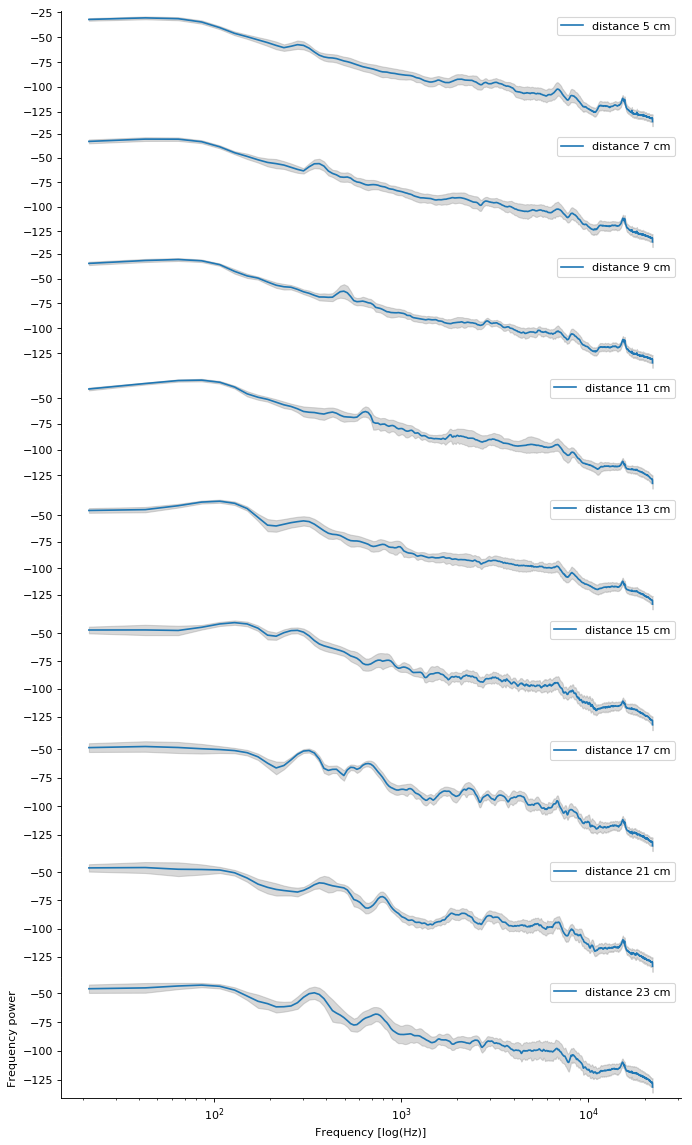

In [15]:
plt.figure(num=None, figsize=(10, 20), dpi=80)
plt.subplots_adjust(hspace=0)
counter = 1

plt.style.use('default')

for dist in psds.distance.sort_values().unique():    
    dat = psds[psds.distance == dist].iloc[:, 2:].values.tolist()
    average = np.mean(dat, axis=0)
    std_dev = np.std(dat, axis=0)
    ax = plt.subplot(10, 1, counter)
    plt.xscale('log')
    counter += 1
    
    plt.plot(f, average, label='distance %d cm' % dist)
    plt.fill_between(f, average-std_dev, average+std_dev, color='grey', alpha=.3)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter < 10:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

Text(0,0.5,'Frequency power')

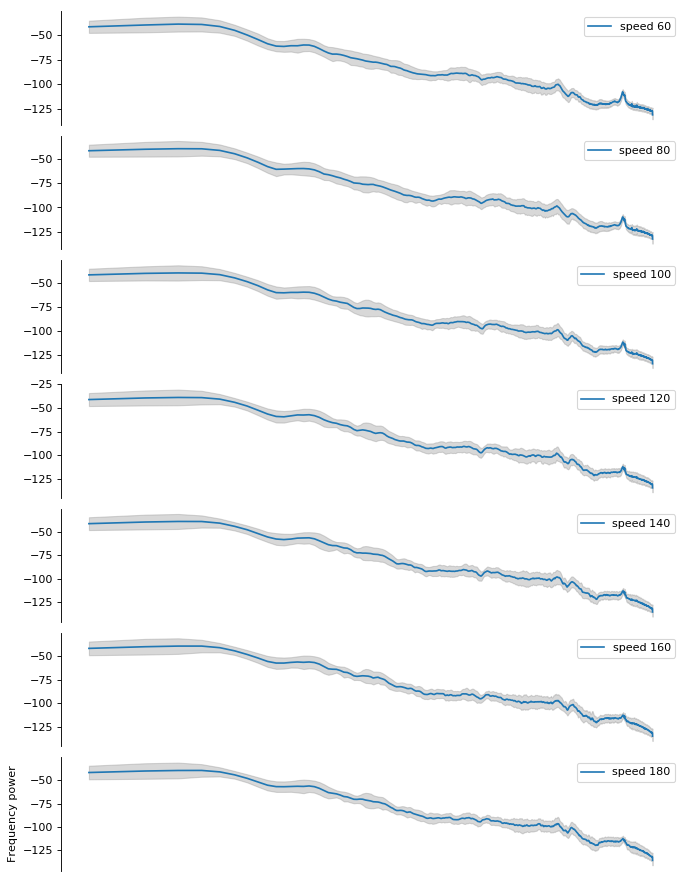

In [16]:
plt.figure(num=None, figsize=(10, 20), dpi=80)
plt.subplots_adjust(hspace=0.1)
counter = 1

for speed in psds.speed.sort_values().unique():    
    dat = psds[psds.speed == speed].iloc[:, 2:].values.tolist()
    average = np.mean(dat, axis=0)
    std_dev = np.std(dat, axis=0)
    
    ax = plt.subplot(10, 1, counter)
    plt.xscale('log')
    counter += 1
    plt.plot(f, average, label='speed %d' % speed)
    plt.fill_between(f, average-std_dev, average+std_dev, color='grey', alpha=.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter < 10:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

In [110]:
# sample the frequency range in steps of 20
from sklearn import preprocessing

scaler = StandardScaler()
x_psds = psds.iloc[:, 2:]
X = pd.DataFrame(preprocessing.scale(x_psds), index=x_psds.index, columns=x_psds.columns)
X_train, X_test, y_train, y_test = train_test_split(X, psds.iloc[:, 0],random_state=42,test_size=.3)

In [113]:
cols = np.array(psds.columns[2:], dtype=np.float32)
p0 = 0
p1 = 0
prev_ret = None

def eval_score(finter):
    global p0
    global p1
    global prev_ret
    freqmid,freqw  = finter.name[0],finter.name[1]
    freqlo,freqhi  = freqmid-freqw/2.,freqmid+freqw/2.
    mask = (freqlo <= cols) & (cols <= freqhi)
    nfreq = mask.sum()
    if 0<=freqlo and freqhi<=22050 and nfreq>0:
        if p0 == cols[mask][0] and p1 == cols[mask][-1]:
            return prev_ret
        p0 = cols[mask][0]
        p1 = cols[mask][-1]
        model = SVR(kernel='rbf', epsilon=.5, C=10.)
        model.fit(X_train.iloc[:, mask], y_train)
        y_pred = model.predict(X_test.iloc[:,mask])
        y_pred = pd.Series(y_pred,index=y_test.index)
        err = y_pred - y_test
        r2_score = model.score(X_test.iloc[:,mask], y_test)
        
        perf = dict(freqlo_actual  = p0,
                    freqhi_actual  = p1,
                    freqmid_actual = (p1+p0)/2,
                    freqw_actual   = p1-p0,
                    nsv  = len(model.support_), # nb of support vectors
                    fsv  = len(model.support_)/float(y_train.count()), # fraction of support vectors
                    r2   = r2_score,
                    RMSE = np.sqrt(np.mean(err**2)), # Root-mean-square error
                    MAE  = np.mean(np.abs(err)))     # Mean absolute error
        #print(np.array(psds.columns[2:], dtype=np.float32)[mask][0])
        print('mid = {:.3f}\trange {:.3f}\t{:.3f}\t --> R2 = {:.5f}'.format(
                                            (p1+p0)/2,
                                            p0, 
                                            p1,
                                            r2_score))
    else:
        perf = dict(freqlo_actual=np.nan,freqhi_actual=np.nan,
                    freqmid_actual=np.nan,freqw_actual=np.nan,
                    nsv=np.nan,fsv=np.nan,r2=np.nan,RMSE=np.nan,MAE=np.nan)
    prev_ret = pd.Series(perf)
    return prev_ret

freqs = np.logspace(1,11,num=51,base=2)*10
fintervals = pd.MultiIndex.from_product([freqs,freqs],names=['freqmid','freqw']).to_frame(index=False)
scores = fintervals.groupby(['freqmid','freqw']).apply(eval_score)
#fintervals.groupby(['freqmid','freqw'])

mid = 21.533	range 21.533	21.533	 --> R2 = 0.65398
mid = 10.767	range 0.000	21.533	 --> R2 = 0.67887
mid = 21.533	range 21.533	21.533	 --> R2 = 0.65398
mid = 32.300	range 21.533	43.066	 --> R2 = 0.75413
mid = 21.533	range 21.533	21.533	 --> R2 = 0.65398
mid = 32.300	range 21.533	43.066	 --> R2 = 0.75413
mid = 21.533	range 0.000	43.066	 --> R2 = 0.78071
mid = 43.066	range 43.066	43.066	 --> R2 = 0.71836
mid = 32.300	range 21.533	43.066	 --> R2 = 0.75413
mid = 43.066	range 21.533	64.600	 --> R2 = 0.84607
mid = 43.066	range 43.066	43.066	 --> R2 = 0.71836
mid = 32.300	range 21.533	43.066	 --> R2 = 0.75413
mid = 43.066	range 21.533	64.600	 --> R2 = 0.84607
mid = 32.300	range 0.000	64.600	 --> R2 = 0.88202
mid = 43.066	range 43.066	43.066	 --> R2 = 0.71836
mid = 53.833	range 43.066	64.600	 --> R2 = 0.83426
mid = 43.066	range 21.533	64.600	 --> R2 = 0.84607
mid = 43.066	range 0.000	86.133	 --> R2 = 0.92438
mid = 43.066	range 43.066	43.066	 --> R2 = 0.71836
mid = 53.833	range 43.066	64.600	 -

mid = 366.064	range 193.799	538.330	 --> R2 = 0.93001
mid = 366.064	range 172.266	559.863	 --> R2 = 0.94291
mid = 366.064	range 129.199	602.930	 --> R2 = 0.95753
mid = 376.831	range 107.666	645.996	 --> R2 = 0.96819
mid = 366.064	range 64.600	667.529	 --> R2 = 0.97922
mid = 366.064	range 0.000	732.129	 --> R2 = 0.98603
mid = 430.664	range 430.664	430.664	 --> R2 = 0.22483
mid = 419.897	range 409.131	430.664	 --> R2 = 0.37905
mid = 430.664	range 409.131	452.197	 --> R2 = 0.44709
mid = 419.897	range 387.598	452.197	 --> R2 = 0.56482
mid = 430.664	range 387.598	473.730	 --> R2 = 0.62958
mid = 419.897	range 366.064	473.730	 --> R2 = 0.70916
mid = 419.897	range 344.531	495.264	 --> R2 = 0.80506
mid = 419.897	range 322.998	516.797	 --> R2 = 0.85039
mid = 419.897	range 301.465	538.330	 --> R2 = 0.87837
mid = 430.664	range 301.465	559.863	 --> R2 = 0.87953
mid = 430.664	range 279.932	581.396	 --> R2 = 0.90339
mid = 430.664	range 258.398	602.930	 --> R2 = 0.91913
mid = 419.897	range 215.332	624

mid = 1108.960	range 1055.127	1162.793	 --> R2 = 0.23513
mid = 1119.727	range 1055.127	1184.326	 --> R2 = 0.26537
mid = 1119.727	range 1033.594	1205.859	 --> R2 = 0.31728
mid = 1108.960	range 1012.061	1205.859	 --> R2 = 0.34038
mid = 1119.727	range 1012.061	1227.393	 --> R2 = 0.35771
mid = 1119.727	range 990.527	1248.926	 --> R2 = 0.42170
mid = 1119.727	range 968.994	1270.459	 --> R2 = 0.46923
mid = 1119.727	range 947.461	1291.992	 --> R2 = 0.48996
mid = 1108.960	range 904.395	1313.525	 --> R2 = 0.57167
mid = 1119.727	range 882.861	1356.592	 --> R2 = 0.62559
mid = 1108.960	range 839.795	1378.125	 --> R2 = 0.70543
mid = 1108.960	range 796.729	1421.191	 --> R2 = 0.78087
mid = 1108.960	range 753.662	1464.258	 --> R2 = 0.82008
mid = 1119.727	range 710.596	1528.857	 --> R2 = 0.83345
mid = 1119.727	range 645.996	1593.457	 --> R2 = 0.84766
mid = 1108.960	range 559.863	1658.057	 --> R2 = 0.88041
mid = 1119.727	range 495.264	1744.189	 --> R2 = 0.89561
mid = 1108.960	range 387.598	1830.322	 --> 

mid = 2228.687	range 1507.324	2950.049	 --> R2 = 0.75475
mid = 2228.687	range 1399.658	3057.715	 --> R2 = 0.77714
mid = 2228.687	range 1270.459	3186.914	 --> R2 = 0.78533
mid = 2228.687	range 1119.727	3337.646	 --> R2 = 0.80629
mid = 2228.687	range 968.994	3488.379	 --> R2 = 0.82701
mid = 2228.687	range 775.195	3682.178	 --> R2 = 0.88638
mid = 2228.687	range 559.863	3897.510	 --> R2 = 0.91264
mid = 2228.687	range 301.465	4155.908	 --> R2 = 0.94764
mid = 2217.920	range 0.000	4435.840	 --> R2 = 0.97666
mid = 2562.451	range 2562.451	2562.451	 --> R2 = 0.03917
mid = 2551.685	range 2540.918	2562.451	 --> R2 = 0.04348
mid = 2562.451	range 2540.918	2583.984	 --> R2 = 0.05205
mid = 2562.451	range 2519.385	2605.518	 --> R2 = 0.10501
mid = 2562.451	range 2497.852	2627.051	 --> R2 = 0.14804
mid = 2562.451	range 2476.318	2648.584	 --> R2 = 0.17228
mid = 2551.685	range 2454.785	2648.584	 --> R2 = 0.18527
mid = 2562.451	range 2454.785	2670.117	 --> R2 = 0.19773
mid = 2562.451	range 2433.252	2691.650

mid = 4457.373	range 4263.574	4651.172	 --> R2 = 0.39826
mid = 4457.373	range 4220.508	4694.238	 --> R2 = 0.42164
mid = 4457.373	range 4198.975	4715.771	 --> R2 = 0.44083
mid = 4457.373	range 4155.908	4758.838	 --> R2 = 0.46621
mid = 4457.373	range 4091.309	4823.438	 --> R2 = 0.49497
mid = 4457.373	range 4048.242	4866.504	 --> R2 = 0.50666
mid = 4457.373	range 3983.643	4931.104	 --> R2 = 0.51960
mid = 4457.373	range 3919.043	4995.703	 --> R2 = 0.55000
mid = 4457.373	range 3832.910	5081.836	 --> R2 = 0.57101
mid = 4457.373	range 3725.244	5189.502	 --> R2 = 0.60408
mid = 4457.373	range 3617.578	5297.168	 --> R2 = 0.65194
mid = 4457.373	range 3488.379	5426.367	 --> R2 = 0.67752
mid = 4457.373	range 3359.180	5555.566	 --> R2 = 0.68771
mid = 4457.373	range 3186.914	5727.832	 --> R2 = 0.70428
mid = 4457.373	range 2993.115	5921.631	 --> R2 = 0.74201
mid = 4457.373	range 2777.783	6136.963	 --> R2 = 0.75235
mid = 4457.373	range 2519.385	6395.361	 --> R2 = 0.79088
mid = 4457.373	range 2239.453	6

mid = 7751.953	range 7622.754	7881.152	 --> R2 = 0.23243
mid = 7751.953	range 7601.221	7902.686	 --> R2 = 0.25070
mid = 7751.953	range 7579.688	7924.219	 --> R2 = 0.27561
mid = 7762.720	range 7558.154	7967.285	 --> R2 = 0.30406
mid = 7762.720	range 7536.621	7988.818	 --> R2 = 0.30592
mid = 7762.720	range 7493.555	8031.885	 --> R2 = 0.36453
mid = 7762.720	range 7450.488	8074.951	 --> R2 = 0.41752
mid = 7762.720	range 7407.422	8118.018	 --> R2 = 0.44476
mid = 7762.720	range 7342.822	8182.617	 --> R2 = 0.46377
mid = 7751.953	range 7278.223	8225.684	 --> R2 = 0.47593
mid = 7762.720	range 7213.623	8311.816	 --> R2 = 0.51343
mid = 7762.720	range 7127.490	8397.949	 --> R2 = 0.54312
mid = 7762.720	range 7041.357	8484.082	 --> R2 = 0.57064
mid = 7762.720	range 6933.691	8591.748	 --> R2 = 0.59007
mid = 7762.720	range 6804.492	8720.947	 --> R2 = 0.60353
mid = 7762.720	range 6653.760	8871.680	 --> R2 = 0.63924
mid = 7751.953	range 6481.494	9022.412	 --> R2 = 0.67835
mid = 7762.720	range 6309.229	9

mid = 11767.896	range 6653.760	16882.031	 --> R2 = 0.76517
mid = 11767.896	range 5900.098	17635.693	 --> R2 = 0.78312
mid = 11757.129	range 5017.236	18497.021	 --> R2 = 0.81387
mid = 11757.129	range 4005.176	19509.082	 --> R2 = 0.83139
mid = 11767.896	range 2863.916	20671.875	 --> R2 = 0.84385
mid = 11757.129	range 1528.857	21985.400	 --> R2 = 0.86531
mid = 13512.085	range 13501.318	13522.852	 --> R2 = 0.02801
mid = 13512.085	range 13479.785	13544.385	 --> R2 = 0.05426
mid = 13512.085	range 13458.252	13565.918	 --> R2 = 0.06966
mid = 13512.085	range 13436.719	13587.451	 --> R2 = 0.08816
mid = 13512.085	range 13415.186	13608.984	 --> R2 = 0.09374
mid = 13512.085	range 13393.652	13630.518	 --> R2 = 0.10260
mid = 13512.085	range 13372.119	13652.051	 --> R2 = 0.11416
mid = 13512.085	range 13329.053	13695.117	 --> R2 = 0.14407
mid = 13512.085	range 13307.520	13716.650	 --> R2 = 0.14627
mid = 13512.085	range 13285.986	13738.184	 --> R2 = 0.15936
mid = 13512.085	range 13242.920	13781.250	 -->

In [114]:
scores.to_csv('data/analysis/model_scores.csv')

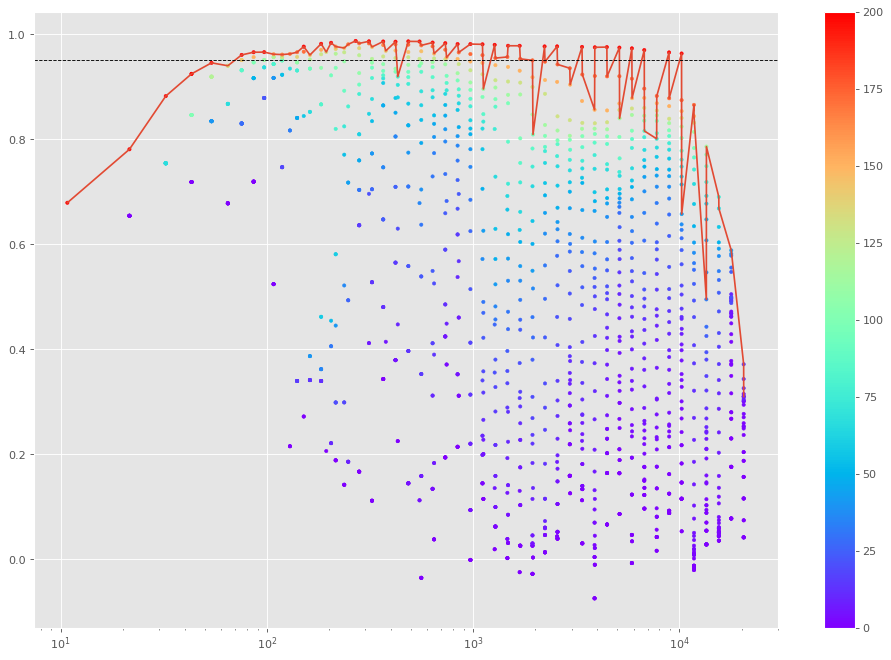

In [115]:
plt.figure(num=None, figsize=(15, 10), dpi=80)
plt.style.use('ggplot')

model_scores = pd.read_csv('data/analysis/model_scores.csv')
model_scores = model_scores.dropna()
f_center = model_scores.loc[:, 'freqmid_actual']
frac_width = (model_scores.loc[:, 'freqhi_actual'] - model_scores.loc[:, 'freqlo_actual']) / f_center
r2 = model_scores.loc[:, 'r2']

# find best performing
sorted_r2 = [ r for _, r in sorted(zip(f_center, r2))]
sorted_center = sorted(f_center)
top = []
highest = sorted_r2[0]
for i in range(1, len(sorted_center)):
    if sorted_center[i] == sorted_center[i-1]:
        highest = max(highest, sorted_r2[i], sorted_r2[i-1])
    else:
        top.append(highest)
        highest = sorted_r2[i]
top.append(highest)

plt.scatter(f_center, r2, marker='.', c=100*frac_width, cmap='rainbow')#, vmax=200, vmin=0)
plt.plot(np.unique(sorted_center), top)
plt.axhline(0.95, linestyle='--', color='k', linewidth=0.8)
plt.xscale('log')
plt.colorbar()

In [81]:
model_scores.head(10)

,freqmid,freqw,MAE,RMSE,freqhi_actual,freqlo_actual,freqmid_actual,freqw_actual,fsv,nsv,r2
0,20.000000,20.000000,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
1,20.000000,22.973967,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
2,20.000000,26.390158,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
3,20.000000,30.314331,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
4,20.000000,34.822023,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
5,20.000000,40.000000,1.908625,2.892795,21.533203,0.000000,10.766602,21.533203,0.662543,2892.0,0.747515
51,22.973967,20.000000,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
52,22.973967,22.973967,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
53,22.973967,26.390158,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461
54,22.973967,30.314331,2.305563,3.344738,21.533203,21.533203,21.533203,0.000000,0.756930,3304.0,0.662461


In [ ]:


def SVR_perf(finter):
    freqmid,freqw  = finter.name[0],finter.name[1]
    freqlo,freqhi  = freqmid-freqw/2.,freqmid+freqw/2.
    #freqlo,freqhi = finter.name[0],finter.name[1]
    mask  = (freqlo <= X.columns) & (X.columns <= freqhi)
    nfreq = mask.sum()
    if 0<=freqlo and freqhi<=22050 and nfreq>0:
    #if freqlo<freqhi and nfreq>0:
        print(finter.name)
        est    = svm.SVR(kernel='rbf',epsilon=.5,C=10) #,gamma=1./47)
        #est    = svm.NuSVR(kernel='rbf',nu = .05,C=5) #, gamma=1./4)
        est.fit(X_train.iloc[:,mask], y_train)
        y_pred = est.predict(X_test.iloc[:,mask])
        y_pred = pd.Series(y_pred,index=y_test.index)
        err    = y_pred - y_test
        perf = dict(freqlo_actual  = X.columns[mask][0],
                    freqhi_actual  = X.columns[mask][-1],
                    freqmid_actual = (X.columns[mask][-1]+X.columns[mask][0])/2,
                    freqw_actual   = X.columns[mask][-1]-X.columns[mask][0],
                    nsv  = len(est.support_), # nb of support vectors
                    fsv  = len(est.support_)/float(y_train.count()), # fraction of support vectors
                    r2   = est.score(X_test.iloc[:,mask], y_test),
                    RMSE = np.sqrt(np.mean(err**2)), # Root-mean-square error
                    MAE  = np.mean(np.abs(err)))     # Mean absolute error
    else:
        perf = dict(freqlo_actual=np.nan,freqhi_actual=np.nan,
                    freqmid_actual=np.nan,freqw_actual=np.nan,
                    nsv=np.nan,fsv=np.nan,r2=np.nan,RMSE=np.nan,MAE=np.nan)
    return pd.Series(perf)

freqs = np.logspace(1,11,num=51,base=2)*10
fintervals = pd.MultiIndex.from_product([freqs,freqs],names=['freqmid','freqw']).to_frame(index=False)
fintervals#.groupby(['freqmid','freqw'])

Data prepared:
 -- samples	6237
 -- features	512
 -- test size	4178
 -- train size	2059


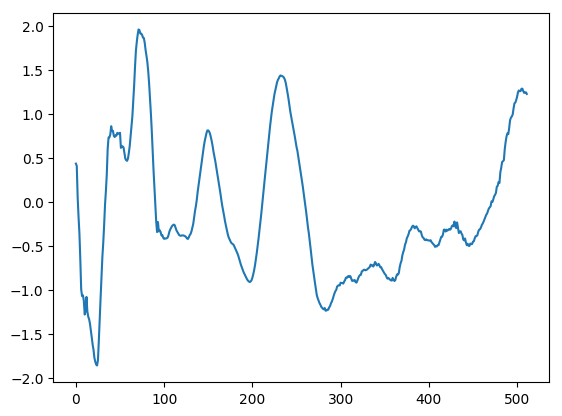

In [77]:
contact_events = []
distance_values = np.array([])
reduce_res_by = 4

for i in range(len(contact_signals)):
    cs = contact_signals.iloc[i, 2:101].tolist()
    contact_events.append(cs)
    ys = [contact_signals.distance[i]] * len(cs)
    distance_values = np.append(distance_values, ys)

contact_events = np.reshape(contact_events, [-1, 2048])
contact_events = [ x[::reduce_res_by] for x in contact_events ]

contact_events = StandardScaler().fit_transform(contact_events)

X_train, X_test, y_train, y_test = train_test_split(contact_events, 
                                                    distance_values, 
                                                    test_size=.33, 
                                                    random_state=42)
print('Data prepared:\n -- samples\t%d\n -- features\t%d\n -- test size\t%d\n -- train size\t%d' 
      % (len(contact_events), len(contact_events[0]), len(X_train), len(X_test)))
plt.plot(X_train[1])

In [78]:
weights = { 'W1' : tf.Variable(tf.random_normal([3, 1, 32])),
            'W2' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W3' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W4' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W5' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W6' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W7' : tf.Variable(tf.random_normal([3, 32, 32])) }

def conv(in_features, kernel, stride=1):
    convolution = tf.nn.conv1d(in_features, kernel, stride=stride, padding='SAME')
    return tf.layers.max_pooling1d(convolution, 3, 2)
    

# build net
x = tf.placeholder(dtype=tf.float32, shape=[None, 512, 1])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
#relative_y = tf.divide(y, 23.)
# window the input
#hann = tf.contrib.signal.hann_window(512, periodic=False, dtype=tf.float32, name=None)
#hann = tf.reshape(hann, shape=[-1, 512, 1])
#x_windowed = tf.multiply(x, hann)

conv1 = conv(x, weights['W1'], stride=2)
conv2 = conv(conv1, weights['W2'], stride=2)
#conv3 = conv(conv2, weights['W3'], stride=2)
#conv4 = conv(conv3, weights['W4'], stride=2)
#conv5 = conv(conv4, weights['W5'], stride=2)
#conv6 = conv(conv5, weights['W6'], stride=2)
#conv7 = conv(conv6, weights['W7'], stride=2)
print(conv2)
flaty = tf.layers.flatten(conv2)
print(flaty)
# output a percentage of antenna length


fc1   = fully_connected(flaty, 512, activation=tf.nn.relu)
fc2   = fully_connected(fc1, 512, activation=tf.nn.relu)
#fc1   = fully_connected(flaty, 128, activation=tf.nn.relu)
fc3   = fully_connected(fc2, 128, activation=tf.nn.relu)
#fc2   = fully_connected(fc1, 128, activation=tf.nn.relu)
sample   = fully_connected(fc3, 1, activation=tf.nn.relu)
#sample = out #tf.multiply(out, 23.)

loss = tf.losses.mean_squared_error(y, sample)
train = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

Tensor("max_pooling1d_1/Squeeze:0", shape=(?, 31, 32), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 992), dtype=float32)


Iteration 9 finished with mean error 0.36419
Iteration 19 finished with mean error 0.20635
Iteration 29 finished with mean error 0.17586
Iteration 39 finished with mean error 0.15729
Iteration 49 finished with mean error 0.10798
Accuracy	0.7015332197614992
Difference	0.3684854910598549
R2 Score	0.9888729793122342
Contact at 11.0 cm < - > 11.6895 cm prediction
Contact at 15.0 cm < - > 15.8042 cm prediction
Contact at 13.0 cm < - > 13.5316 cm prediction
Contact at 11.0 cm < - > 11.3350 cm prediction
Contact at 5.0 cm < - > 4.4084 cm prediction
Contact at 7.0 cm < - > 7.0464 cm prediction
Contact at 15.0 cm < - > 15.2434 cm prediction
Contact at 21.0 cm < - > 20.9734 cm prediction
Contact at 5.0 cm < - > 5.0369 cm prediction
Contact at 9.0 cm < - > 8.9341 cm prediction
Mean Divergence	0.3777170741714396


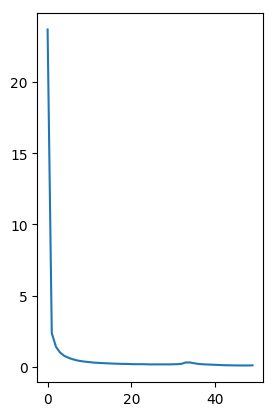

In [79]:
tf.set_random_seed(42)

EPOCHS = range(50)
BATCH_SIZE = 15
loss_summary = []

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in EPOCHS:
        epoch_mse = []
        for index, offset in enumerate(range(0, len(X_train), BATCH_SIZE)):
            xs = X_train[offset:offset+BATCH_SIZE]
            xs = np.reshape(xs, [len(xs), len(xs[0]), 1])
            ys = y_train[offset:offset+BATCH_SIZE]
            ys = np.reshape(ys, [len(ys), 1])
            _, mse = sess.run([train, loss], feed_dict={ x : xs, y : ys })
            epoch_mse.append(mse)
        if (i+1) % 10 == 0:
            print('Iteration {} finished with mean error {:.5f}'.format(i, np.mean(epoch_mse)))
        loss_summary.append(np.mean(epoch_mse))
    
    predictions = []

    X_test = np.reshape(X_test, [-1, len(X_test[0]), 1])
    y_test = np.reshape(y_test, [-1, 1])
    for i in range(len(X_test)):
        p = sess.run(sample, feed_dict={ x : [X_test[i]], y : [y_test[i]] })
        predictions.append(p)

    predictions = np.ravel(predictions)
    false_predictions = np.sum([ (p - t) > 0.2 for p, t in zip(predictions, y_test)  ])

    accuracy = float(len(predictions)) / float((len(predictions) + false_predictions))

    print('Accuracy\t{}'.format(accuracy))
    
    difference = np.mean(np.power(np.subtract(predictions, np.ravel(y_test)), 2))
    print('Difference\t{}'.format(difference))
    
    r2 = r2_score(np.ravel(y_test), predictions)
    print('R2 Score\t{}'.format(r2))
        
plt.subplot(1, 2, 1)
plt.plot(loss_summary)
for i in range(10):
    print("Contact at {} cm < - > {:.4f} cm prediction".format(np.ravel(y_test)[i], predictions[i]))
print("Mean Divergence\t{}".format(np.mean(np.abs(np.ravel(y_test) - predictions))))